In [506]:
import pickle
import eelbrain as eb
from eelbrain import load       # for loading NDVars, pickled TRFs, etc.
from eelbrain import plot       # for visualization
from eelbrain import boosting 
from eelbrain import NDVar
from eelbrain import find_peaks
from eelbrain import MneExperiment
import os
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import numpy as np

sns.set_theme(style="whitegrid", palette="dark")

In [507]:
#Get word onset TRF for each subject
def load(file_path):
    
    boostresults = eel.load.unpickle(file_path)

    #combine everything
    data = eel.combine([subject_result[1].h_scaled[2] for subject_result in boostresults],dim_intersection=True, name = 'group trf') 
    
    mean_trf = data.mean('case')
    
    return mean_trf

def plot_trf(file_path):
    
    mean_trf = load(file_path)
    
    times = mean_trf.time
    
    plt.figure(figsize=(8, 6))

    #Use this to get TRF for all sensors, no highlighting
    #trf_plot = plt.plot(times, mean_trf.x.T)#, color = 'gray')

    #--------- plot the highest peak
    t_0 = mean_trf.std('sensor').argmax('time')
    val = mean_trf.sub(time=t_0).x
    idx = np.argmax(np.abs(val))
    sensor_name = mean_trf.sensor.names[idx]
   
    trf = mean_trf.sub(sensor = sensor_name)

    time_ar = trf.time
    trf_ar = trf.x

    trf_plot = plt.plot(time_ar, trf_ar, color = 'black', linewidth = 2.5, label = f"Sensor: {sensor_name} ")

    
    #------------------plot the rest of the TRFs
    all_trf = mean_trf.x
    for i in range(mean_trf.x.shape[0]):
        if i == idx:
            continue
        plt.plot(times, all_trf[i], color='steelblue', linewidth=0.8)
        
    # Labelling

    plt.legend()
    print ("limit", plt.xlim())
    plt.xlabel("Lags (ms)", fontsize=18, weight = 'bold')
    plt.ylabel("TRF Amplitude", fontsize=18, weight = 'bold')



# Plot Eelbrain Topomaps, not used in this
def plot_topo(file_path):

    mean_trf = load(file_path)
    
    mean_trf_window_1 = mean_trf.sub(time = (0,0.2))
    mean_trf_window_2 = mean_trf.sub(time = (0.2,0.4))
    mean_trf_window_3 = mean_trf.sub(time = (0.4,0.6))

   
    t_1 = mean_trf_window_1.std('sensor').argmax('time')
    t_2 = mean_trf_window_2.std('sensor').argmax('time')
    t_3 = mean_trf_window_3.std('sensor').argmax('time')

    
    print("peak 1: ", t_1, "peak_2", t_2, "peak_3", t_3)

    #for plain singular topomap
    topo_plot = plot.Topomap(mean_trf.sub(time = (0.240,0.260)).mean('time'), clip = 'circle')

    #for one peak
    plot = plot.TopoButterfly(mean_trf, t = t_1, w = 10, h = 4, clip = 'circle')

    #for multiple
    p = plot.TopoArray(mean_trf, t=[t_1, t_2, t_3], w=6, h=4, clip='circle')

    
#For mne topo plot; used in this code
def mne_topo(file_path):
    
    mean_trf = load(file_path)

    info = eb.load.unpickle("C:/Users/stell/downloads/exampleInfo.pickle")

    # Get info data
    ch_names = mean_trf.sensor.names.copy()
    sfreq = 1 / mean_trf.time.tstep
    ch_types = "mag"
    tmin = mean_trf.time.tmin
    trfMat = mean_trf.x

    
    newInfo = mne.create_info(ch_names, sfreq, ch_types)
    allChs = info["chs"]
    newChs = []
    for i, ch_name in enumerate(ch_names):
         for j in allChs:
             if j["ch_name"] == ch_name:
                 newInfo["chs"][i]["loc"] = j["loc"]
    
    evoked = mne.EvokedArray(data=trfMat, info=newInfo, tmin=tmin)

    # Look at the three manin standard response windows
    mean_trf_window_1 = mean_trf.sub(time = (0,0.2))
    mean_trf_window_2 = mean_trf.sub(time = (0.2,0.4))
    mean_trf_window_3 = mean_trf.sub(time = (0.4,0.6))

   
    t_1 = mean_trf_window_1.std('sensor').argmax('time')
    t_2 = mean_trf_window_2.std('sensor').argmax('time')
    t_3 = mean_trf_window_3.std('sensor').argmax('time')


    # For just TRF, do evoked.plot()
    evoked.plot_topomap(times=[t_1, t_2, t_3], average=.01, size = 2, outlines = 'head')
    

limit (-0.272, 0.8720000000000001)


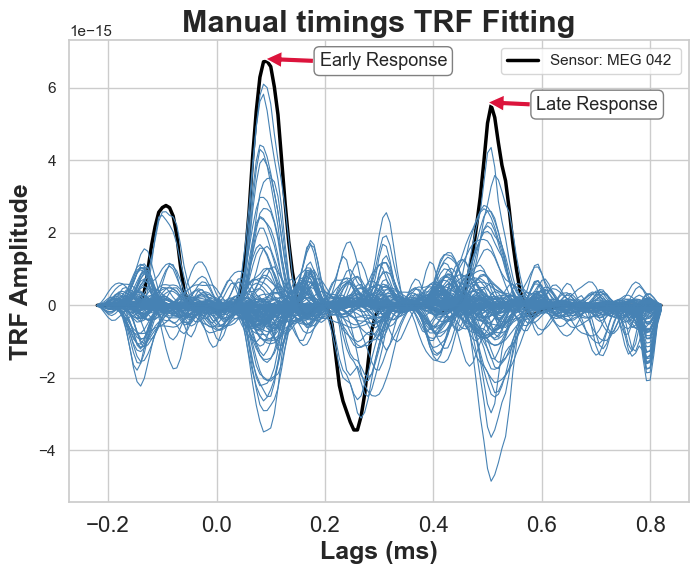

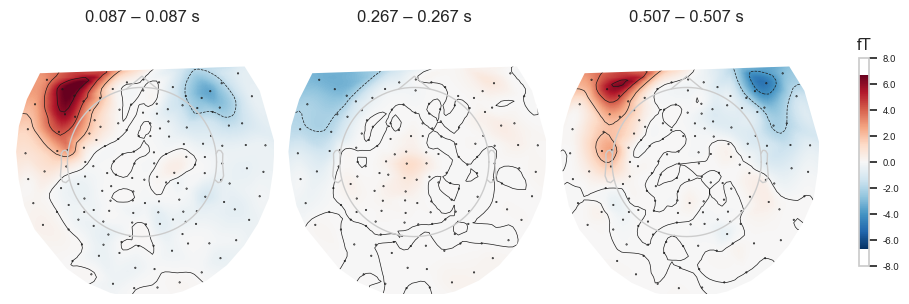

In [508]:
annotated = "C:/Users/stell/OneDrive/Desktop/CANS_LAB/TRF Stuff/annotated_word_onsets_trfs.pickle"


trf_plot = plot_trf(annotated)


plt.title("Manual timings TRF Fitting", weight = "bold", fontsize = 22)
plt.xticks(fontsize = 16)
plt.annotate('Early Response', xy = (0.09,6.8e-15), xytext = (0.19, 6.6e-15), fontsize = 13, family = 'Arial',  
             arrowprops=dict(facecolor='crimson'), bbox=dict(boxstyle="round,pad=0.3",
            facecolor="white", edgecolor="gray"))

plt.annotate('Late Response', xy = (0.5,5.6e-15), xytext = (0.59, 5.4e-15), fontsize = 13,  family = 'Arial',  
             arrowprops=dict(facecolor='crimson'), bbox=dict(boxstyle="round,pad=0.3",
            facecolor="white", edgecolor="gray"))

plt.savefig("annotated_trf.png")

topo_plot = mne_topo(annotated)








limit (-0.272, 0.8720000000000001)


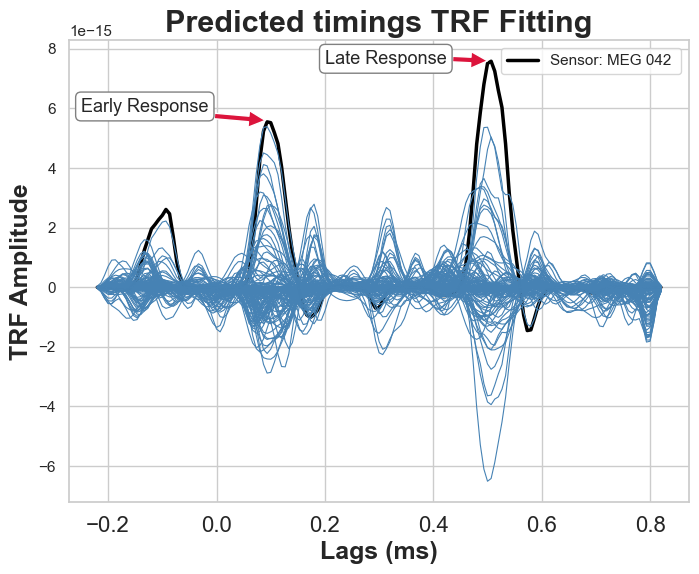

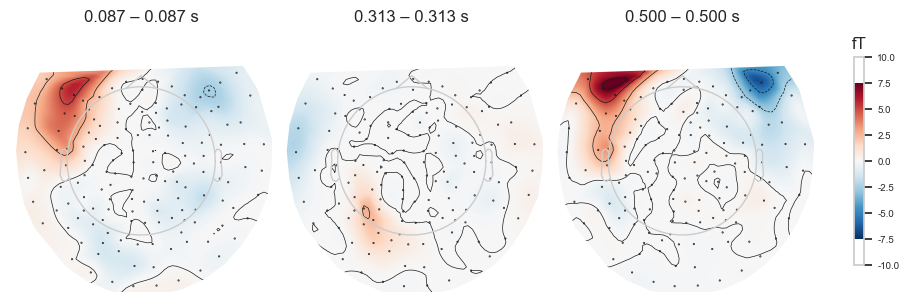

In [509]:
regression = "C:/Users/stell/OneDrive/Desktop/CANS_LAB/TRF Stuff/regression_word_onsets_trfs.pickle"

trf_plot  = plot_trf(regression)


plt.title("Predicted timings TRF Fitting", weight = "bold", fontsize = 22)
plt.xticks(fontsize = 16)
plt.annotate('Early Response', xy = (0.09,5.6e-15), xytext = (-0.25, 5.9e-15), fontsize = 13, family = 'Arial',  
             arrowprops=dict(facecolor='crimson'), bbox=dict(boxstyle="round,pad=0.3",
            facecolor="white", edgecolor="gray"))

plt.annotate('Late Response', xy = (0.5,7.6e-15), xytext = (0.2, 7.5e-15), fontsize = 13,  family = 'Arial',  
             arrowprops=dict(facecolor='crimson'), bbox=dict(boxstyle="round,pad=0.3",
            facecolor="white", edgecolor="gray"))

plt.savefig("regression_trf.png")


topo_plot = mne_topo(regression)


limit (-0.272, 0.8720000000000001)


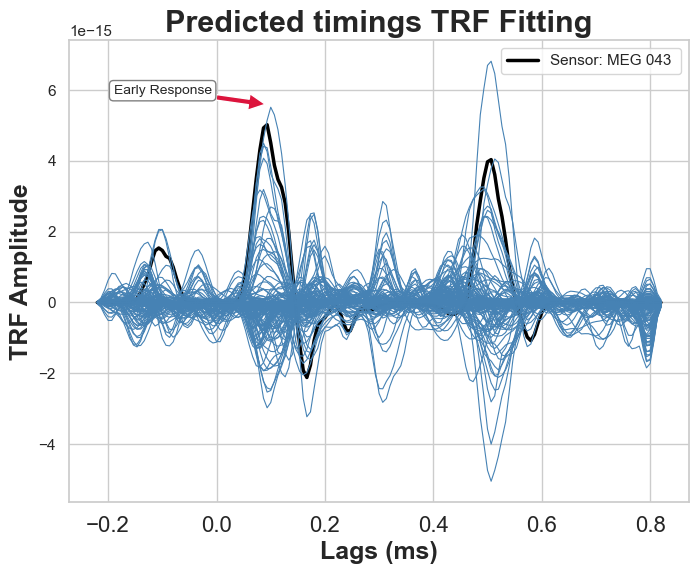

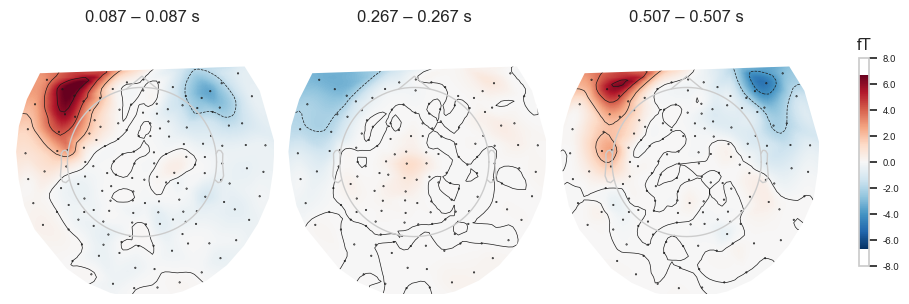

In [510]:
mfa = "C:/Users/stell/OneDrive/Desktop/CANS_LAB/TRF Stuff/mfa_word_onsets_trfs.pickle"


trf_plot = plot_trf(mfa)

plt.title("Predicted timings TRF Fitting", weight = "bold", fontsize = 22)
plt.xticks(fontsize = 16)
plt.annotate('Early Response', xy = (0.09,5.6e-15), xytext = (-0.19, 5.9e-15), fontsize = 10, family = 'Arial',  
             arrowprops=dict(facecolor='crimson'), bbox=dict(boxstyle="round,pad=0.3",
            facecolor="white", edgecolor="gray"))

plt.annotate('Late Response', xy = (0.5,7.6e-15), xytext = (0.23, 7.87e-15), fontsize = 10,  family = 'Arial',  
             arrowprops=dict(facecolor='crimson'), bbox=dict(boxstyle="round,pad=0.3",
            facecolor="white", edgecolor="gray"))

plt.savefig("regression_trf.png")



topo_plot = mne_topo(annotated)


limit (-0.272, 0.8720000000000001)


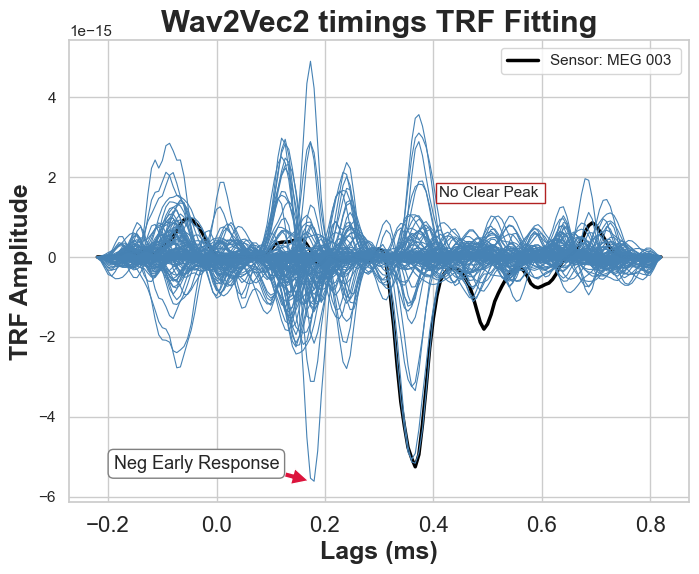

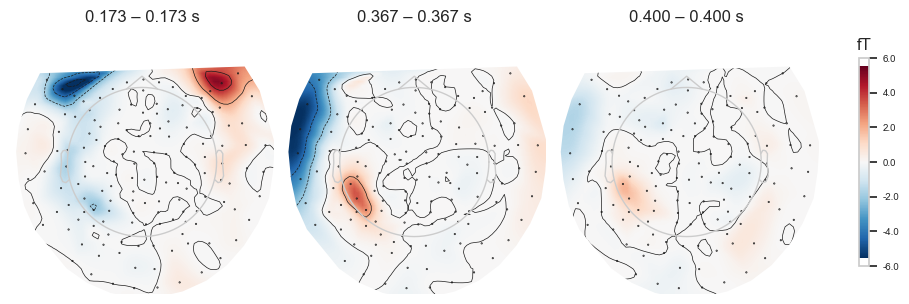

In [511]:
wav2vec2 = "C:/Users/stell/OneDrive/Desktop/CANS_LAB/TRF Stuff/wav2vec_word_onsets_trfs.pickle"

trf_plot  = plot_trf(wav2vec2)


plt.title("Wav2Vec2 timings TRF Fitting", weight = "bold", fontsize = 22)
plt.xticks(fontsize = 16)
plt.annotate('Neg Early Response', xy = (0.17,-5.6e-15), xytext = (-0.19, -5.3e-15), fontsize = 13, family = 'Arial',  
             arrowprops=dict(facecolor='crimson'), bbox=dict(boxstyle="round,pad=0.3",
            facecolor="white", edgecolor="gray"))

plt.annotate('No Clear Peak ', xy = (0.41, 1.5e-15), xytext = (0.41, 1.5e-15), fontsize = 11,  family = 'Arial',  
             bbox=dict(boxstyle="square",pad=0.2,
            facecolor="white", edgecolor="firebrick"))
plt.legend()
plt.savefig("wav2vec2_trf.png")


topo_plot = mne_topo(wav2vec2)
